<a href="https://colab.research.google.com/github/estavrionto/Dota2_wr/blob/main/dotabuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm, trange
import time
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
# %config Completer.use_jedi = False

In [ ]:
# 03 oct 20

In [2]:
# 27 dec 2022
# extracting trends table
# Create an URL object
trends_url = "https://www.dotabuff.com/heroes/trends"
# Create object page
trends_page = requests.get(trends_url, headers = {'User-agent': 'personal_study'})
# Obtain page's information
trends_soup = BeautifulSoup(trends_page.text)
# trends_soup

# Obtain information from tag <table>
trends_table = trends_soup.findAll('table')[0]

In [3]:
# 27 dec 2022
# extracting the trends table into df
trends_header = [i.text for i in trends_table.find_all('tr')[2].find_all('th')]
trends_header = ['hero', 'wr_start', 'wr_current', 'wr_change', 'wr_trend', 'pr_start', 'pr_current', 'pr_change', 'pr_trend','title']


df_trends = []
for row in trends_table.find_all('tr'):

    try:
        link = row.find_all('a')[0]['href']
        link = link.split('/')[-1]
        title = row.find_all('img')[0]['title']
#         print(link)
    except:
        pass
    row = [i.text for i in row.find_all('td')]
#     print(row)
    if row !=[]:
        row[0] = link
        row.append(title)
        df_trends.append(row)


df_trends = pd.DataFrame(df_trends)
df_trends.columns = trends_header

df_trends = df_trends.drop(columns=['wr_trend','pr_trend'])
float_header  = ['wr_start', 'wr_current', 'wr_change', 'pr_start', 'pr_current', 'pr_change', ]
for i in float_header:
    df_trends[i] = df_trends[i].replace('','0.0%').str.rstrip('%').astype('float')
#     df_trends[i] = df_trends[i].replace('',)
df_trends


,hero,wr_start,wr_current,wr_change,pr_start,pr_current,pr_change,title
0,lifestealer,49.59,52.97,3.38,5.24,7.54,2.30,Lifestealer
1,phantom-lancer,46.11,48.49,2.38,3.28,4.37,1.09,Phantom Lancer
2,tidehunter,47.15,49.41,2.27,4.45,5.23,0.78,Tidehunter
3,dawnbreaker,49.57,51.56,1.98,3.09,3.62,0.53,Dawnbreaker
4,juggernaut,50.63,52.45,1.82,14.66,16.71,2.04,Juggernaut
...,...,...,...,...,...,...,...,...
120,mirana,46.82,44.15,-2.67,11.66,9.39,-2.27,Mirana
121,omniknight,52.96,49.71,-3.25,4.55,3.34,-1.21,Omniknight
122,sand-king,53.35,48.56,-4.80,16.17,12.08,-4.09,Sand King
123,ringmaster,53.59,47.30,-6.29,14.39,9.73,-4.66,Ringmaster


In [4]:
# 27 dec 2022
# extracting names and winrates
df_wr = df_trends[['hero','wr_current','title']]
df_wr.columns = ['hero','wr','title']
df_wr = df_wr.sort_values(by='wr',ascending=False)
df_wr = df_wr.reset_index(drop=True)
df_wr['id'] = df_wr.index
df_wr.head()
# df_wr['hero'].tolist()

,hero,wr,title,id
0,abaddon,55.95,Abaddon,0
1,wraith-king,55.59,Wraith King,1
2,lich,54.99,Lich,2
3,medusa,54.05,Medusa,3
4,warlock,53.93,Warlock,4


In [17]:
def extract_counters(Hero):
    # print(Hero)
    # url_counter = f'https://www.dotabuff.com/heroes/{Hero}/counters'
    url_counter = f'https://www.dotabuff.com/heroes/{Hero}/counters?date=week'
    # print(Hero, url_counter)
    # Create object page
    page_counter = requests.get(url_counter, headers = {'User-agent': 'personal_study'})
    # Obtain page's information
    soup_counter = BeautifulSoup(page_counter.text)
    # trends_soup

    # Obtain information from tag <table>
    table_counter = soup_counter.findAll('table')[3]
#     print(table_counter.find_all('tr')[1].find_all('td')[0])
    header_counter = ['','title_B', 'disadvantage_AB', 'wr_AB', 'num_matches_AB']
    table_counter = [
        [j.text for j in i.find_all('td')]
        for i in table_counter.find_all('tr')
        if i.find_all('td') != []
    ]
    df_counters = pd.DataFrame(table_counter)
#     print(df_counters)
    df_counters.columns = header_counter
    df_counters['wr_AB'] = df_counters['wr_AB'].str.rstrip('%').astype('float')
    df_counters['disadvantage_AB'] = df_counters['disadvantage_AB'].str.rstrip('%').astype('float')
    df_counters['num_matches_AB'] = df_counters['num_matches_AB'].str.replace(',','').astype('int')
    return df_counters

extract_counters(df_wr['hero'][0])


,,title_B,disadvantage_AB,wr_AB,num_matches_AB
0,,Elder Titan,5.49,49.91,2294
1,,Dark Seer,4.21,51.43,2650
2,,Lone Druid,3.55,51.13,6769
3,,Pangolier,3.30,56.73,3277
4,,Doom,3.26,56.73,8925
...,...,...,...,...,...
119,,Bounty Hunter,-2.64,57.21,9011
120,,Skywrath Mage,-2.66,57.79,10387
121,,Arc Warden,-2.73,56.20,4484
122,,Axe,-3.59,57.27,25038


In [18]:
heros = df_wr['hero'].tolist()
df_all_counters = []
p_bar = tqdm(heros)
for hero in p_bar:
    p_bar.set_description(f'Working on "{hero}"\n')
    df_counter_now = extract_counters(Hero=hero)
    df_counter_now['hero_A'] = hero
#     display(df_counter_now)
    try:
        df_all_counters = pd.concat([df_all_counters,df_counter_now])
#         break
    except TypeError:
        df_all_counters = df_counter_now
df_all_counters.head()

  0%|          | 0/125 [00:00<?, ?it/s]

,,title_B,disadvantage_AB,wr_AB,num_matches_AB,hero_A
0,,Elder Titan,5.49,49.91,2294,abaddon
1,,Dark Seer,4.21,51.43,2650,abaddon
2,,Lone Druid,3.55,51.13,6769,abaddon
3,,Pangolier,3.30,56.73,3277,abaddon
4,,Doom,3.26,56.73,8925,abaddon


In [19]:
df_t = df_all_counters.merge(df_wr,left_on='title_B',right_on='title',how='inner')
df_t = df_t.rename(columns={'hero':'hero_B','id':'id_B'})
df_t = df_t.merge(df_wr,left_on='hero_A',right_on='hero',how='inner')
df_t = df_t.rename(columns={'id':'id_A'})
filter_cols = ['id_A','id_B','wr_AB']
df_t = df_t[filter_cols]
df_t = df_t.sort_values(by=['id_A','id_B'])
df_t

,id_A,id_B,wr_AB
118,0,1,53.30
47,0,2,50.96
32,0,3,50.02
89,0,4,51.80
106,0,5,54.36
...,...,...,...
15405,124,119,47.40
15404,124,120,47.71
15412,124,121,46.13
15408,124,122,48.96


In [20]:
df_plot = np.identity(125)*50
# df_plot = np.zeros([124,124])
for row in df_t.values:
    a = int(row[0])
    b = int(row[1])
    if a!=b:
        df_plot[a,b] = row[2]
    else:
        df_plot[a,b] = 50

df_plot =  pd.DataFrame(df_plot)
df_plot = df_plot.rename(columns= df_wr['hero'],index=df_wr['hero'])
df_plot

,abaddon,wraith-king,lich,medusa,warlock,shadow-shaman,legion-commander,lifestealer,axe,night-stalker,...,faceless-void,doom,tusk,sven,monkey-king,templar-assassin,mirana,batrider,windranger,chen
abaddon,50.00,53.30,50.96,50.02,51.80,54.36,54.34,56.35,57.27,53.08,...,59.67,56.73,57.40,57.98,59.53,60.88,60.11,64.61,55.78,60.21
wraith-king,46.70,50.00,50.12,48.27,47.63,53.52,54.50,52.83,54.44,53.73,...,59.83,60.34,56.85,61.13,59.38,61.43,60.33,64.31,55.53,59.65
lich,49.04,49.88,50.00,49.96,49.12,51.44,51.87,54.39,52.01,50.72,...,56.59,57.64,58.78,58.48,60.63,59.65,57.06,61.45,52.83,60.38
medusa,49.99,51.74,50.04,50.00,49.14,54.28,54.60,55.37,51.07,51.86,...,56.42,59.86,58.73,59.49,57.96,61.84,58.31,63.15,53.73,60.38
warlock,48.20,52.36,50.88,50.86,50.00,53.57,50.90,53.21,54.80,50.85,...,57.42,58.16,57.34,58.38,59.68,59.92,57.42,60.27,52.41,61.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
templar-assassin,39.12,38.57,40.35,38.16,40.08,40.73,42.27,45.65,41.44,44.25,...,47.49,47.92,48.49,53.60,49.78,50.00,48.37,45.81,43.90,52.29
mirana,39.89,39.67,42.94,41.69,42.58,43.98,42.81,45.82,43.10,42.70,...,49.85,50.13,49.35,51.39,51.67,51.63,50.00,52.55,45.95,53.87
batrider,35.39,35.69,38.55,36.85,39.73,38.40,41.14,41.45,43.40,43.08,...,45.27,49.45,49.55,44.44,50.02,54.19,47.45,50.00,43.00,51.04
windranger,44.22,44.47,47.17,46.27,47.59,47.40,46.91,49.62,45.58,48.57,...,50.62,54.59,53.87,53.56,56.55,56.10,54.05,57.02,50.00,57.08


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


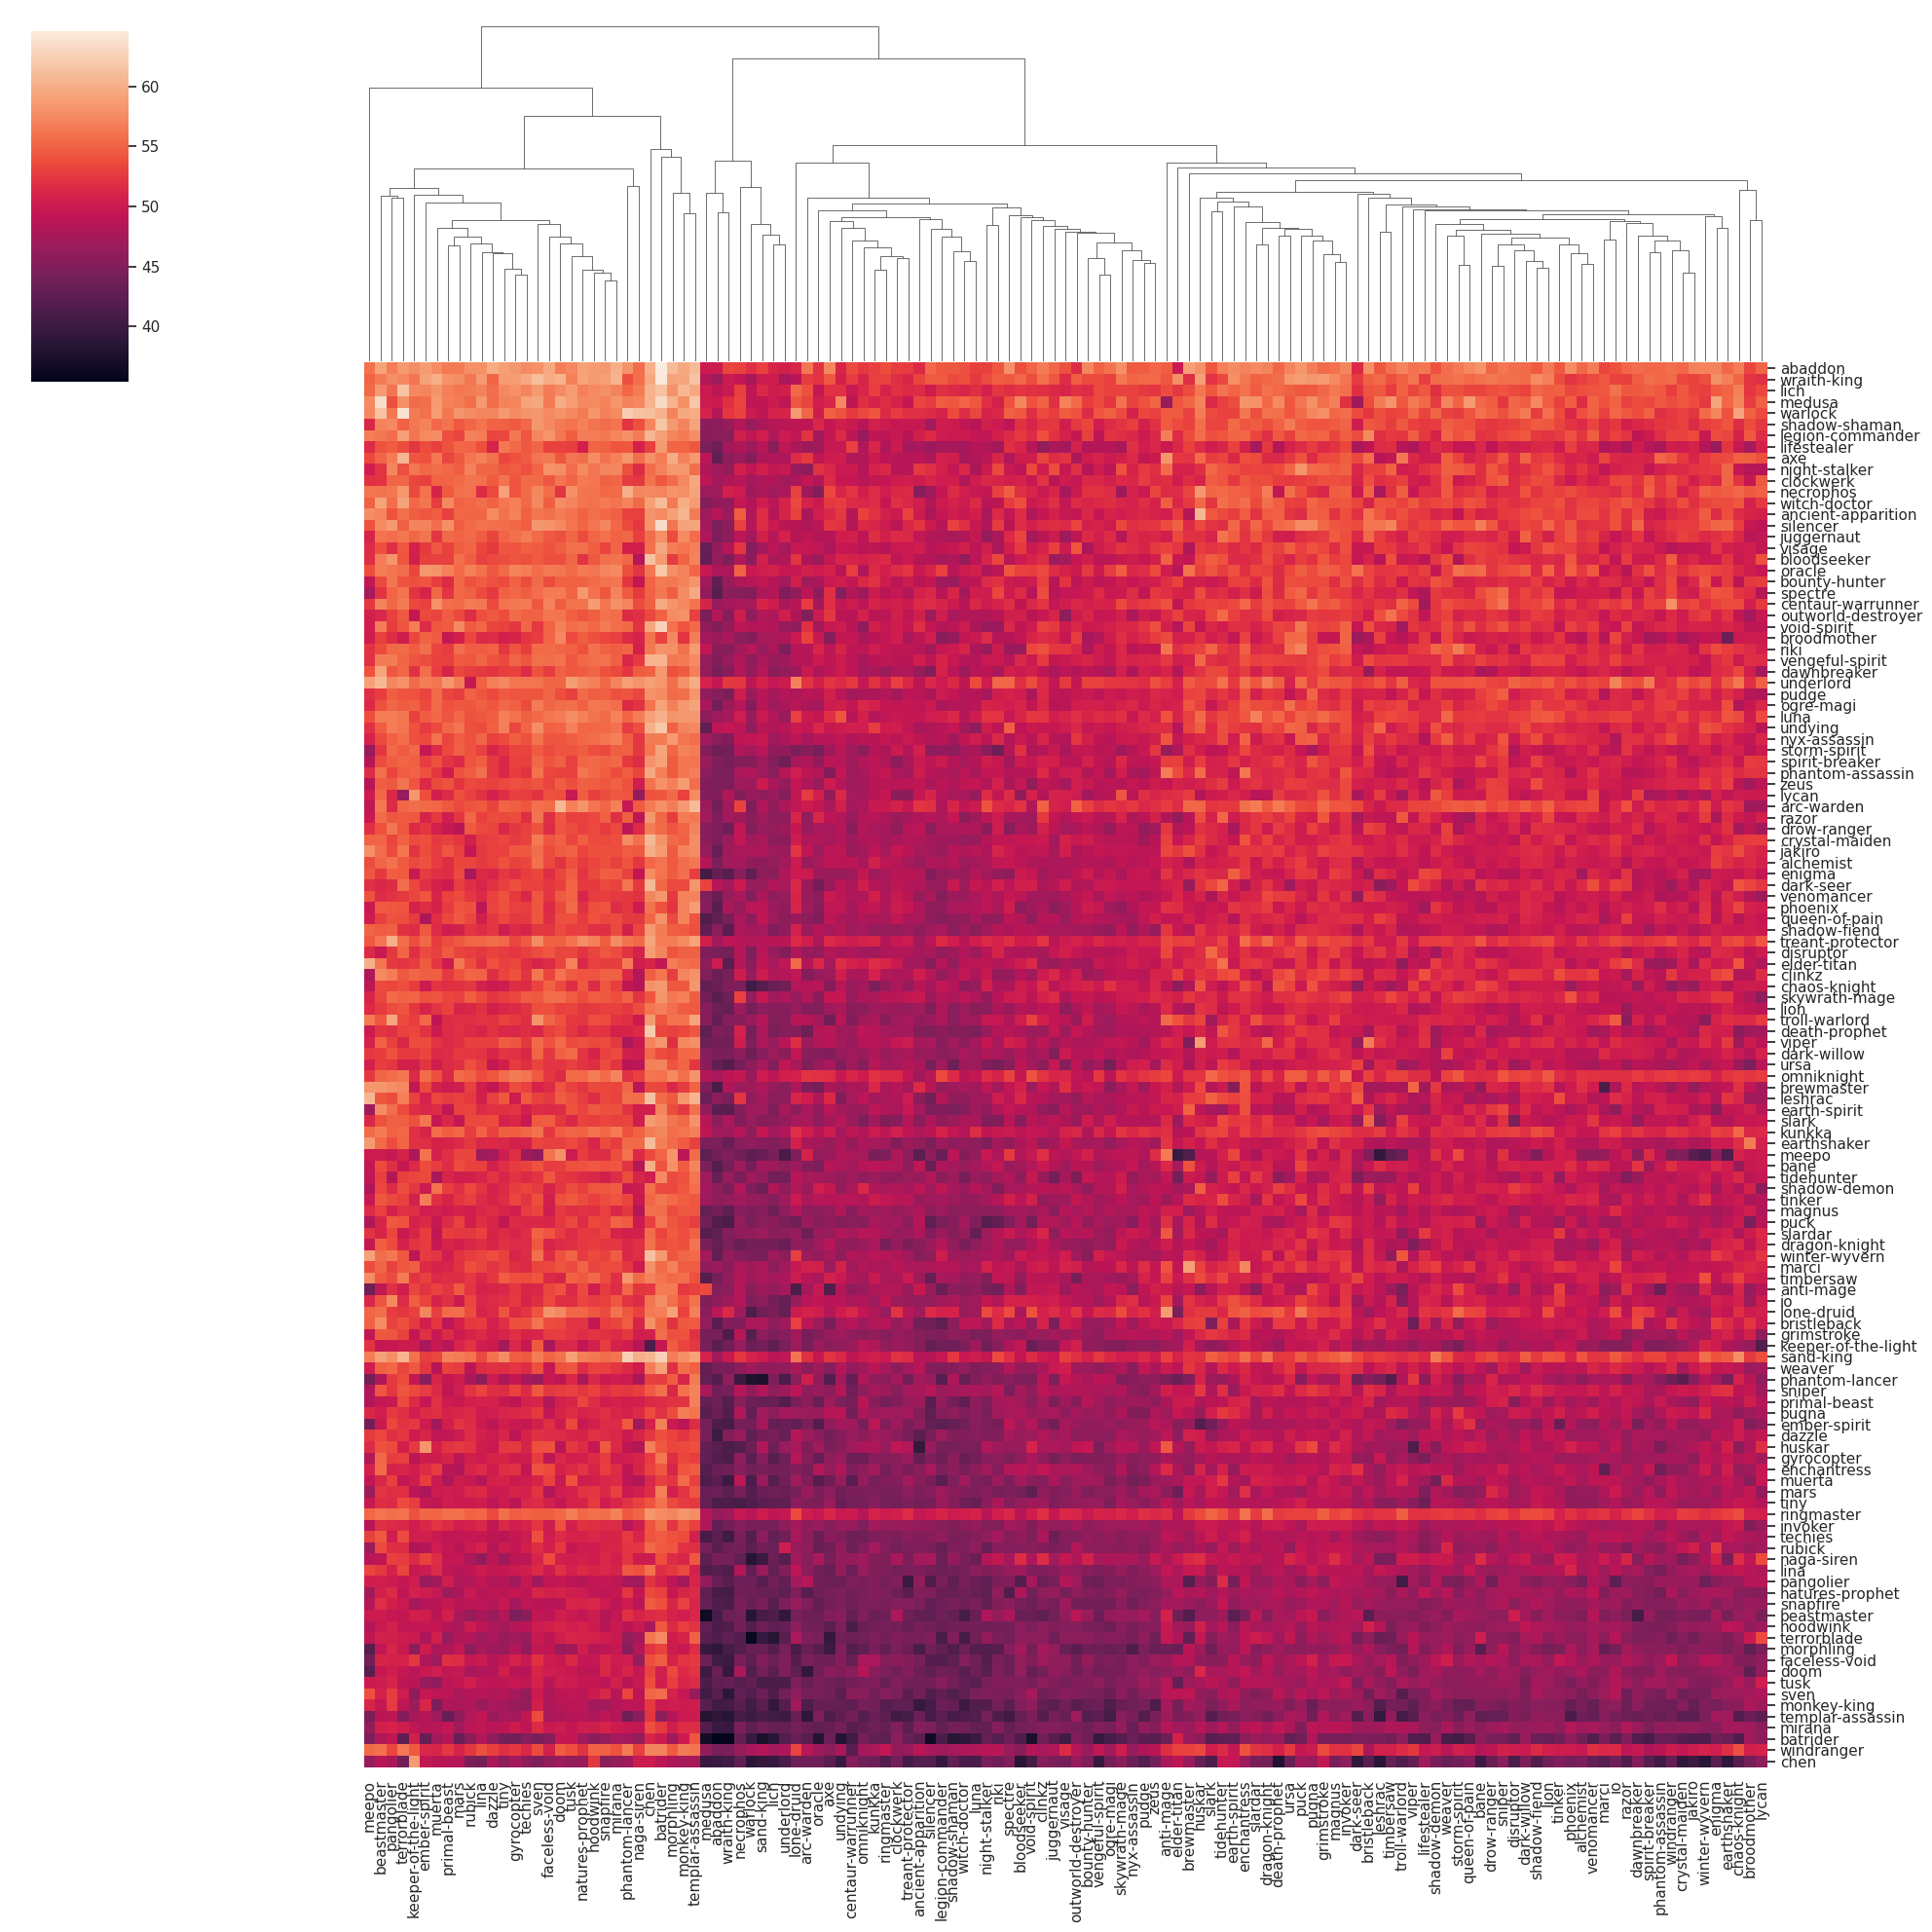

In [21]:
# df_plot.plot()
sns.set(font_scale=1)

# Default plot
sns.clustermap(
    df_plot,
    yticklabels=True,
    xticklabels=True,
    figsize=(20,20),
    row_cluster=False,
)
# Show the graph
plt.show()

# # Standardize or Normalize every column in the figure
# # Standardize:
# sns.clustermap(df_plot, standard_scale=1,yticklabels=True,xticklabels=True,figsize=(20,20))
# plt.show()

# # Normalize
# sns.clustermap(df_plot, z_score=1,yticklabels=True,xticklabels=True,figsize=(20,20))
# plt.show()

# # plot with correlation distance
# sns.clustermap(df_plot, metric="correlation",yticklabels=True,xticklabels=True,figsize=(20,20))
# plt.show()

# # plot with euclidean distance
# sns.clustermap(df_plot, metric="euclidean",yticklabels=True,xticklabels=True,figsize=(20,20))
# plt.show()

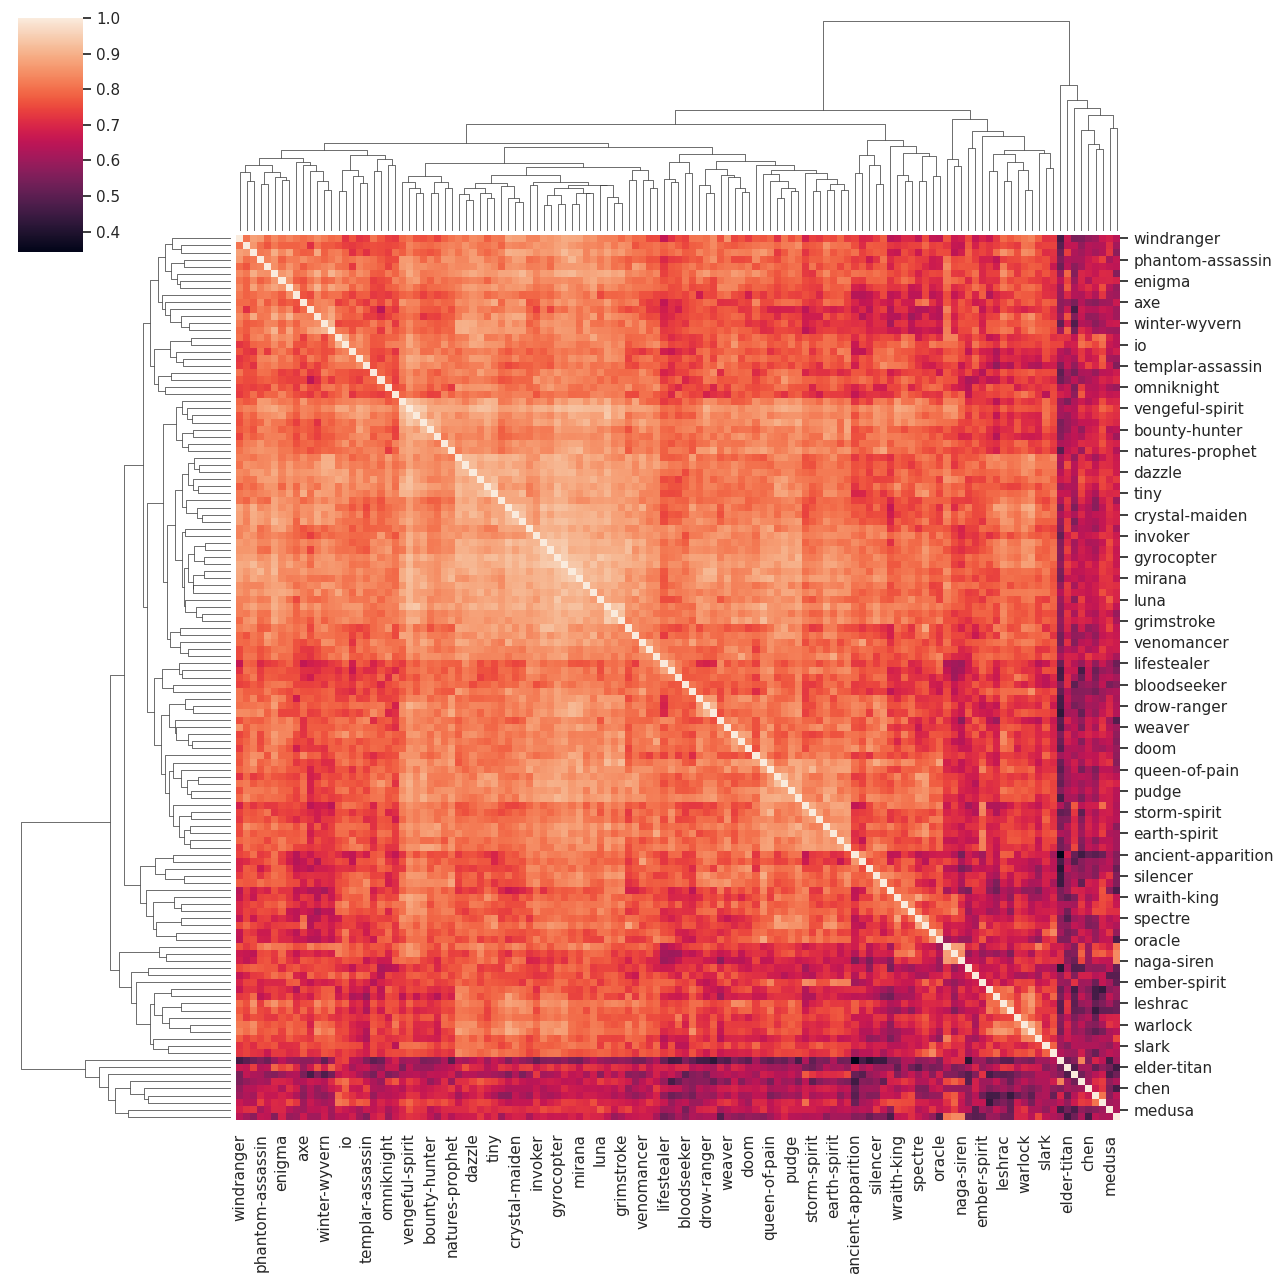

In [13]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

correlations = df_plot.corr()
correlations_array = np.asarray(df_plot.corr())

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage, method="average", figsize=(13, 13))

In [ ]:
# Q1.1
plt.figure()
plt.plot(np.arange(max_time+1),avg_states_UNVAC,label=f'UNVAC',linewidth=2)
plt.plot(np.arange(max_time+1),avg_states_FRIENDS,label=f'FRIENDS',linewidth=2)
plt.plot(np.arange(max_time+1),avg_states_RANDOM,label=f'RANDOM',linewidth=2)

# plt.plot(np.arange(1,101),cost_s,label=f'softmax',linewidth=2)

plt.title(f'HW4 Q1.3')
plt.xlabel("t",fontweight="bold")
plt.ylabel("number of nodes infected",fontweight="bold")
legend = plt.legend(title="Strategy",fontsize=7,loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

In [14]:
# finding standard deviations of heros counter winrates
stds = []
dev_50 = []
num_50 = []
for hero in heros:
    df_i = df_all_counters.copy(deep=True)
    df_i = df_i[df_i['hero0'] == hero]
    std = df_i['wr'].std()
    stds.append(std)

    d50 = sum((df_i['wr']-50)**2)
    dev_50.append(d50)

    n50 = df_i[df_i['wr']>=50]
    n50 = len(n50)
    num_50.append(n50)

#     display(df_i)
#     break
df_wr['dev_50'] = dev_50
df_wr['num_50'] = num_50
df_wr['std'] = stds
df_wr['temp'] = df_wr['std']*df_wr['wr']/100
df_wr1 = df_wr.sort_values(by=['wr'],ascending=False)
df_wr1 = df_wr.sort_values(by=['dev_50'],ascending=False)
df_wr1 = df_wr.sort_values(by=['num_50'],ascending=False)

df_wr1.head(20)

KeyError: 'hero0'

In [ ]:
num_50 = []
for hero in heros:
    df_i = df_all_counters.copy(deep=True)
    df_i = df_i[df_i['hero0'] == hero]
    n50 = len(df_i[df_i['wr']>=50])
    num_50.append

underlord 103
beastmaster 34
outworld-destroyer 73
arc-warden 109
batrider 3
tinker 94
brewmaster 63
broodmother 24
meepo 98
monkey-king 8
terrorblade 6
wraith-king 72
ember-spirit 21
omniknight 111
io 46
shadow-demon 7
techies 80
legion-commander 110
disruptor 79
abaddon 88
marci 26
riki 113
lina 15
tiny 23
spectre 108
puck 16
centaur-warrunner 100
weaver 56
necrophos 67
silencer 117
shadow-shaman 90
elder-titan 49
chaos-knight 58
phantom-assassin 46
natures-prophet 1
dark-willow 71
crystal-maiden 100
zeus 74
tidehunter 77
ursa 64
medusa 58
templar-assassin 3
venomancer 68
sniper 45
earth-spirit 12
mars 23
clockwerk 63
lich 103
drow-ranger 116
spirit-breaker 56
morphling 13
gyrocopter 66
faceless-void 42
enchantress 15
witch-doctor 102
pudge 80
doom 26
keeper-of-the-light 11
slardar 92
magnus 39
timbersaw 23
axe 102
visage 98
lycan 103
hoodwink 58
snapfire 22
mirana 104
phoenix 59
warlock 98
phantom-lancer 69
pugna 13
grimstroke 42
lion 24
naga-siren 87
dazzle 113
invoker 28
huskar 68